In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [4]:
data_path = "data/NonLinear_data.npy"
data = np.load(data_path, allow_pickle=True).item()
X, y = data["X"], data["labels"]
print(X.shape, y.shape)

(300, 2) (300,)


In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

In [ ]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [13]:
input_dims = X_train.shape[1]
output_dims = len(set(y_train))
hidden_dims = 128
model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(
    device
)
model

MLP(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

In [14]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [18]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training Phase
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()

    for X_samples, y_samples in train_loader:
        # Ensure inputs have the correct dtype and are on the correct device
        X_samples = X_samples.to(device).float()  # Convert to float32
        y_samples = y_samples.to(device)

        # Forward pass
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

        # Store predictions and targets for accuracy
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    # Compute average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Concatenate predictions and targets for accuracy
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    # Validation Phase
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()

    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            # Ensure inputs have the correct dtype and are on the correct device
            X_samples = X_samples.to(device).float()  # Convert to float32
            y_samples = y_samples.to(device)

            # Forward pass
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            # Store predictions and targets for accuracy
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    # Compute average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Concatenate predictions and targets for accuracy
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # Epoch Summary
    print(
        f"EPOCH {epoch + 1}/{epochs}:\t"
        f"Train Loss: {train_loss:.3f}\tTrain Acc: {train_acc:.3f}\t"
        f"Val Loss: {val_loss:.3f}\tVal Acc: {val_acc:.3f}"
    )

EPOCH 1/100:	Train Loss: 1.070	Train Acc: 0.443	Val Loss: 1.019	Val Acc: 0.433
EPOCH 2/100:	Train Loss: 0.927	Train Acc: 0.557	Val Loss: 0.943	Val Acc: 0.533
EPOCH 3/100:	Train Loss: 0.859	Train Acc: 0.581	Val Loss: 0.900	Val Acc: 0.417
EPOCH 4/100:	Train Loss: 0.823	Train Acc: 0.581	Val Loss: 0.875	Val Acc: 0.383
EPOCH 5/100:	Train Loss: 0.790	Train Acc: 0.571	Val Loss: 0.878	Val Acc: 0.400
EPOCH 6/100:	Train Loss: 0.765	Train Acc: 0.576	Val Loss: 0.856	Val Acc: 0.383
EPOCH 7/100:	Train Loss: 0.748	Train Acc: 0.557	Val Loss: 0.856	Val Acc: 0.433
EPOCH 8/100:	Train Loss: 0.759	Train Acc: 0.533	Val Loss: 0.872	Val Acc: 0.483
EPOCH 9/100:	Train Loss: 0.743	Train Acc: 0.610	Val Loss: 0.837	Val Acc: 0.400
EPOCH 10/100:	Train Loss: 0.731	Train Acc: 0.576	Val Loss: 0.836	Val Acc: 0.400
EPOCH 11/100:	Train Loss: 0.733	Train Acc: 0.571	Val Loss: 0.830	Val Acc: 0.400
EPOCH 12/100:	Train Loss: 0.716	Train Acc: 0.600	Val Loss: 0.839	Val Acc: 0.400
EPOCH 13/100:	Train Loss: 0.714	Train Acc: 0.562	

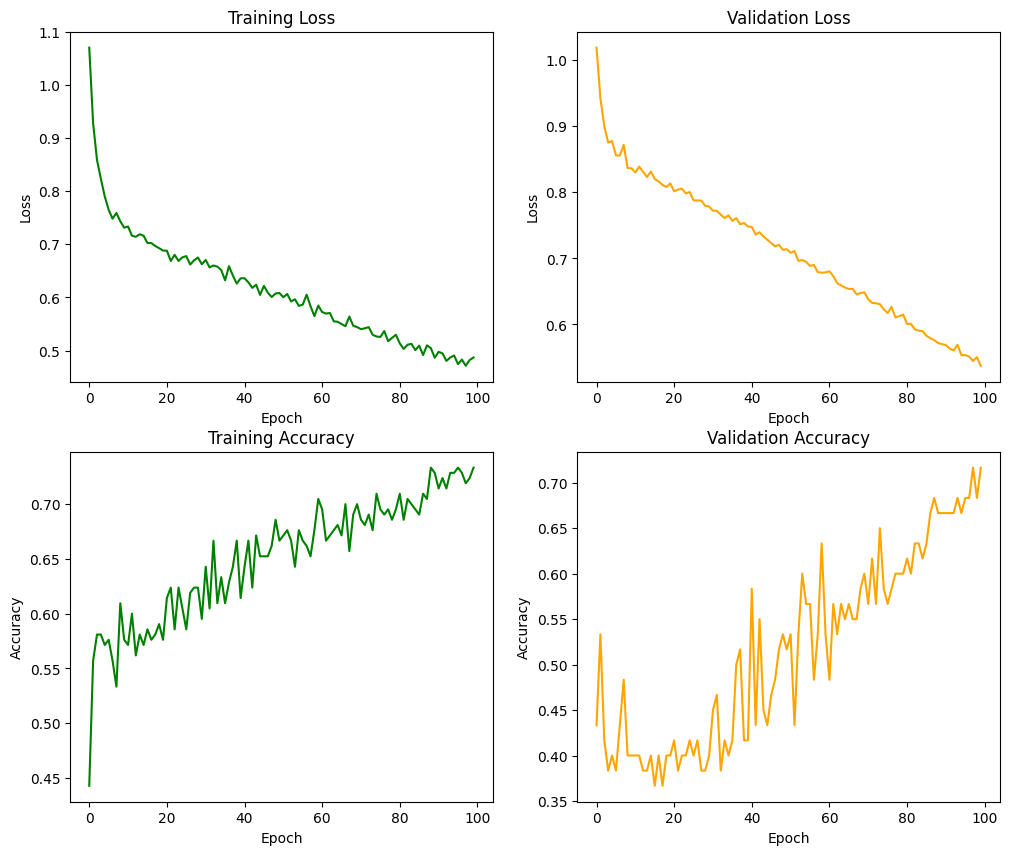

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()

In [21]:
test_target = []
test_predict = []
model.eval()

with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device).float()  # Convert to float32
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print("Evaluation on test set:")
print(f"Accuracy: {test_acc}")

Evaluation on test set:
Accuracy: 0.8
